Kernel : base (Python 3.9.7)

# Prédiction : Log2_GHGEmissionIntensity

In [1]:
to_predict = 'Log2_GHGEmissionsIntensity'

# I. INSTALLER ENVIRONNEMENT DE TRAVAIL

Installer packages/librairies nécessaires

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns
import os
from os import listdir
import missingno as msno
from zipfile import ZipFile
import requests
import math
from numpy import loadtxt

import lightgbm as lgb
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedStratifiedKFold

from time import process_time
import time
import shap
shap.initjs()

# II. OPEN DF19

In [3]:
df19 = pd.read_csv('df19.csv', sep=',')
df19.head(3)

,PrimaryPropertyType,PropertyName,LargestPropertyUseType,ENERGYSTARScore,Log2_Age,Log2_#Buildings,Log2_#Floors,%SteamUse,%Electricity,%NaturalGas,...,Lake_Union,Magnolia#Queen_Anne,North,Northeast,Northwest,Southeast,Southwest,Log2_GHGEmissionsIntensity,Log2_SiteEUIWN,Log2_SourceEUIWN
0,Hotel,Mayflower park hotel,Hotel,60.0,6.475733,0.0,3.584963,27.730164,54.605997,17.663840,...,0,0,0,0,0,0,0,1.500802,6.397461,7.562242
1,Hotel,Paramount Hotel,Hotel,61.0,4.321928,0.0,3.459432,0.000000,38.660907,61.339093,...,0,0,0,0,0,0,0,1.516015,6.613237,7.487036
2,Hotel,5673-The Westin Seattle,Hotel,43.0,5.554589,0.0,5.357552,29.711310,68.230746,2.057944,...,0,0,0,0,0,0,0,1.130931,6.610287,7.931329


In [4]:
df19['ENERGYSTARScore'].isna().sum()

527

# III. TESTER DIFFERENTS MODELES POUR DU ML

III.1 Trouver le meilleur modèle et ses hyperparams pour prédire Log2_GHGEmissionsIntensity

In [5]:
def MachineLearning(energystarscore=True, Model='XGBoost', Y=to_predict, drop_NaN=True):
    dico = {'RF':RandomForestRegressor(),"LR":LinearRegression(), "XGBoost":XGBRegressor(), 
    'LGB':lgb.LGBMRegressor(),'SVR':SVR(), 'GBR':GradientBoostingRegressor()}
    if drop_NaN==False: #garder toutes les lignes (même avec NaN dans col EnergyStarScore car pas utlisée)
        df = df19
    else:
        df = df19[df19['ENERGYSTARScore'].notna()]
    model=dico[Model]
    y = df[Y]
    if energystarscore==False: #avec ou sans ENERYStarScore
        X = df.iloc[:,4:36]
    else:
        X = df.iloc[:,3:36]
    
    if Model=='RF' or Model=='GBR':
        param_grid={
        'n_estimators': [80, 100, 150, 200],
        'max_depth': [5, 7, 9, 11, 13],
        'max_features': [3, 5, 7, 9, 11]
        }
        gs = GridSearchCV(model, 
        param_grid=param_grid, cv = KFold(random_state=50, shuffle=True, n_splits=10), scoring="r2") #trouver les hyperparamètres
        result = gs.fit(X,y)
        model = RandomForestRegressor(n_estimators=result.best_params_['n_estimators'],
        max_depth=result.best_params_['max_depth'], max_features=result.best_params_['max_features'])
    elif Model=='XGBoost':
        param_grid={
        'n_estimators': [80, 100, 150, 200, 250],
        'max_depth': [1, 2, 3, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'min_child_weight': [3, 5, 7],
        }
        gs = GridSearchCV(model, 
        param_grid=param_grid, cv = KFold(random_state=50, shuffle=True, n_splits=10), scoring="r2") #trouver les hyperparamètres
        result = gs.fit(X,y)
        model = XGBRegressor(n_estimators=result.best_params_['n_estimators'],
        max_depth=result.best_params_['max_depth'],
        learning_rate=result.best_params_['learning_rate'], min_child_weight=result.best_params_['min_child_weight'])
    elif Model=='LR':
        param_grid={}
        gs = GridSearchCV(model, param_grid = param_grid ,cv = KFold(random_state=50, shuffle=True, n_splits=10), scoring="r2") #trouver les hyperparamètres
        result = gs.fit(X,y)
        model = LinearRegression() 
    elif Model=='LGB':
        param_grid={'num_leaves':[10,20,50,80], 'min_child_samples':[5,10,15],'max_depth':[-1,1,5,10],
             'learning_rate':[0.02, 0.05,0.1],'reg_alpha':[0.01,0.03, 0.05]}
        gs = GridSearchCV(model, 
        param_grid=param_grid, cv = KFold(random_state=50, shuffle=True, n_splits=5), scoring="r2") #trouver les hyperparamètres
        result = gs.fit(X,y)
        model = lgb.LGBMRegressor(num_leaves=result.best_params_['num_leaves'],
        min_child_samples=result.best_params_['min_child_samples'], max_depth=result.best_params_['max_depth'],
        learning_rate=result.best_params_['learning_rate'], reg_alpha=result.best_params_['reg_alpha'])
    elif Model=='SVR':
        param_grid = {'C': [1, 2, 5, 7, 10, 15],
            'gamma': [0.00001, 0.00005, 0.0001, 0.001],
            'epsilon': [0.001, 0.01, 0.1, 0.2]}
        gs = GridSearchCV(model, 
        param_grid=param_grid, cv = KFold(random_state=50, shuffle=True, n_splits=10), scoring="r2") #trouver les hyperparamètres
        result = gs.fit(X,y)
        model = SVR(C=result.best_params_['C'],
        gamma=result.best_params_['gamma'], epsilon=result.best_params_['epsilon'])

     
    X = np.array(X)
    y = np.array(y)
    folds= KFold(random_state=50, shuffle=True, n_splits=10).split(X, y) #définir le kfold
    y_pred = []
    y_true = []
    for train, test in folds:
        y_pred.append(model.fit(X[train], y[train]).predict(X[test]))
        y_true.append(y[test])
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    l = [Model,result.best_params_,energystarscore, drop_NaN, Y, round(mse, 4), 
    round(rmse, 4), round(mae, 4), round(r2, 4)]
    results = pd.DataFrame(l).T
    results.columns = ['Model', 'Hyperparams','NRJStarScore','drop_NaN','y','MSE','RMSE','MAE','R2']
    return results, y_true, y_pred, Model, Y, round(r2, 4), result.best_params_, X[train], y[train], X[test]

In [6]:
def MLs_compared(Y=to_predict):
    l = []
    l2 = []
    dico = {False:'sans_EnergyStarScore', True:'avec_EnergyStarScore'}
    for ele2 in [True, False]:
        if ele2==True:
            for ele in [False, True]:
                for elt2 in ['RF', 'LR', 'XGBoost', 'LGB', 'SVR', 'GBR']:
                    t1_start = time.time()
                    df = MachineLearning(Model=elt2, Y=Y, energystarscore=ele, drop_NaN=ele2)
                    t1_stop = time.time()
                    delta = round((t1_stop-t1_start), 2)
                    l2.append(delta)
                    sns.scatterplot(x=df[1], y=df[2]).set(title=f'{df[3]} model (R2={df[5]}, {dico[ele]}, drop_NaN={ele2})')
                    plt.xlabel(f'y_test ({df[4]})')
                    plt.ylabel('y_predict')
                    plt.savefig(f'Scatter_plots/{df[3]}_to_predict_{df[4]}_{dico[ele]}_dropNaN={ele2}.png')
                    plt.clf()
                    l.append(df[0])
        else:
            for elt2 in ['RF', 'LR', 'XGBoost', 'LGB', 'SVR', 'GBR']:
                t1_start = time.time()
                df = MachineLearning(Model=elt2, Y=Y, energystarscore=False, drop_NaN=ele2)
                t1_stop = time.time()
                delta = round((t1_stop-t1_start), 2)
                l2.append(delta)
                sns.scatterplot(x=df[1], y=df[2]).set(title=f'{df[3]} model (R2={df[5]}, {dico[False]}, drop_NaN={ele2})')
                plt.xlabel(f'y_test ({df[4]})')
                plt.ylabel('y_predict')
                plt.savefig(f'Scatter_plots/{df[3]}_to_predict_{df[4]}_{dico[False]}_dropNaN={ele2}.png')
                plt.clf()
                l.append(df[0])
    df2 = pd.concat(l)
    df2 = df2.reset_index(drop=True)
    df2.insert(2, 'Time_(s)', l2)
    df2.to_csv(f'MLs_compared_{Y}_all.csv', index=False, header=True)
    return df2

In [7]:
MLs_compared() #pas nécessaire de relancer : 42 min!

III.2 Comparer les résultats des différents modèles

In [8]:
df20 = pd.read_csv(f'MLs_compared_{to_predict}_all.csv', sep=',')

In [9]:
df20.head(3)

,Model,Hyperparams,Time_(s),NRJStarScore,drop_NaN,y,MSE,RMSE,MAE,R2
0,RF,"{'max_depth': 11, 'max_features': 7, 'n_estima...",147.00,False,True,Log2_GHGEmissionsIntensity,0.7323,0.8558,0.6345,0.7286
1,LR,{},0.05,False,True,Log2_GHGEmissionsIntensity,0.8377,0.9153,0.6727,0.6896
2,XGBoost,"{'learning_rate': 0.2, 'max_depth': 2, 'min_ch...",236.25,False,True,Log2_GHGEmissionsIntensity,0.7304,0.8547,0.6376,0.7293


In [10]:
l = ["Sans_NRJStarS+drop_NaN"]*6 + ['Avec_NRJStarS+drop_Nan']*6 + ["Sans_NRJStarS"]*6

In [11]:
df21 = df20.copy()

In [12]:
df21.insert(5, "Group", l)

In [13]:
df21

,Model,Hyperparams,Time_(s),NRJStarScore,drop_NaN,Group,y,MSE,RMSE,MAE,R2
0,RF,"{'max_depth': 11, 'max_features': 7, 'n_estima...",147.00,False,True,Sans_NRJStarS+drop_NaN,Log2_GHGEmissionsIntensity,0.7323,0.8558,0.6345,0.7286
1,LR,{},0.05,False,True,Sans_NRJStarS+drop_NaN,Log2_GHGEmissionsIntensity,0.8377,0.9153,0.6727,0.6896
2,XGBoost,"{'learning_rate': 0.2, 'max_depth': 2, 'min_ch...",236.25,False,True,Sans_NRJStarS+drop_NaN,Log2_GHGEmissionsIntensity,0.7304,0.8547,0.6376,0.7293
3,LGB,"{'learning_rate': 0.05, 'max_depth': -1, 'min_...",147.48,False,True,Sans_NRJStarS+drop_NaN,Log2_GHGEmissionsIntensity,0.7294,0.8541,0.6287,0.7297
4,SVR,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.0001}",48.25,False,True,Sans_NRJStarS+drop_NaN,Log2_GHGEmissionsIntensity,0.7545,0.8686,0.6242,0.7204
5,GBR,"{'max_depth': 5, 'max_features': 9, 'n_estimat...",125.72,False,True,Sans_NRJStarS+drop_NaN,Log2_GHGEmissionsIntensity,0.8194,0.9052,0.6814,0.6964
6,RF,"{'max_depth': 13, 'max_features': 11, 'n_estim...",167.81,True,True,Avec_NRJStarS+drop_Nan,Log2_GHGEmissionsIntensity,0.5050,0.7106,0.5004,0.8129
7,LR,{},0.06,True,True,Avec_NRJStarS+drop_Nan,Log2_GHGEmissionsIntensity,0.5562,0.7458,0.5168,0.7939
8,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'min_ch...",273.03,True,True,Avec_NRJStarS+drop_Nan,Log2_GHGEmissionsIntensity,0.4096,0.6400,0.4508,0.8482
9,LGB,"{'learning_rate': 0.1, 'max_depth': 5, 'min_ch...",148.90,True,True,Avec_NRJStarS+drop_Nan,Log2_GHGEmissionsIntensity,0.4325,0.6577,0.4551,0.8397


Comparer les R2 => best XGBoost avec EnergyStarScore + drop_NaN

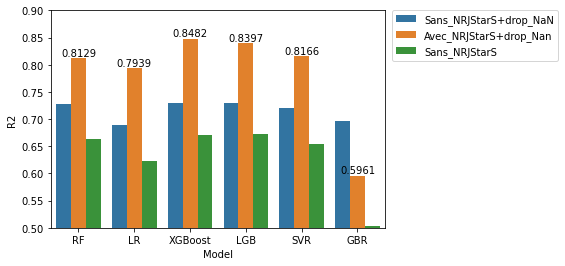

In [14]:
ax = sns.barplot(data=df21, x="Model", y="R2", hue="Group")
ax.set(ylim=(0.5, 0.9))
ax.bar_label(ax.containers[1])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

Comparer le time (s)

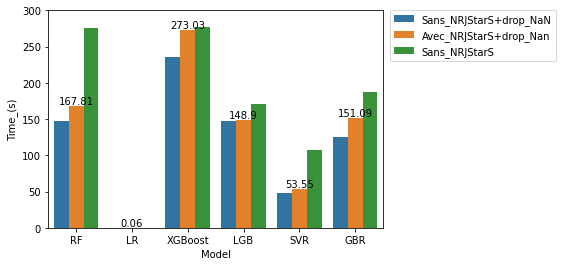

In [15]:
ax = sns.barplot(data=df21, x="Model", y="Time_(s)", hue="Group")
ax.set(ylim=(0, 300))
ax.bar_label(ax.containers[1])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

Scatter plot R2 vs Time

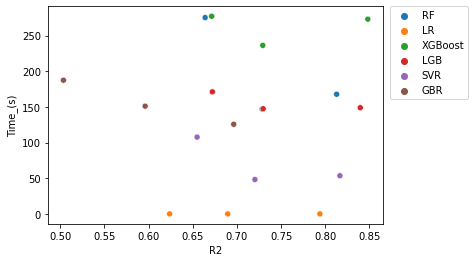

In [16]:
sns.scatterplot(data=df21, x="R2", y="Time_(s)", hue="Model")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

Comparer le MSE (ou MAE)

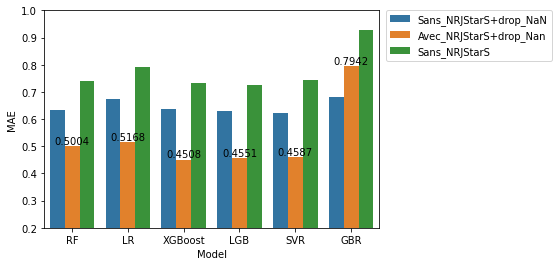

In [43]:
ax = sns.barplot(data=df21, x="Model", y="MAE", hue="Group")
ax.set(ylim=(0.2, 1))
ax.bar_label(ax.containers[1])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

/!\ Le meilleur modèle est XGBoost avec EnergyStarScore+drop_NaN

III.3 Comparer le meilleur modèle avec une valeur moyenne de y_pred.

In [21]:
y_true, y_pred = MachineLearning(energystarscore=True, Model='XGBoost', Y=to_predict, drop_NaN=True)[1:3] #récupérer y_true

In [23]:
y_true.mean(), len(y_true), type(y_true)

(-0.41662494156898416, 981, numpy.ndarray)

In [24]:
y_mean = np.array([y_true.mean()]*len(y_true))

In [25]:
def y_moy():
    Model = 'y_moy'
    energystarscore = True
    drop_NaN = True
    Y = to_predict
    mse = mean_squared_error(y_true, y_mean)
    r2 = r2_score(y_true, y_mean)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_mean)
    l = [Model,np.nan,energystarscore, drop_NaN, Y, round(mse, 4), 
    round(rmse, 4), round(mae, 4), round(r2, 4)]
    results = pd.DataFrame(l).T
    results.columns = ['Model', 'Hyperparams','NRJStarScore','drop_NaN','y','MSE','RMSE','MAE','R2']
    return results

In [26]:
y_moy()

,Model,Hyperparams,NRJStarScore,drop_NaN,y,MSE,RMSE,MAE,R2
0,y_moy,NaN,True,True,Log2_GHGEmissionsIntensity,2.6986,1.6427,1.3397,0.0


<AxesSubplot:>

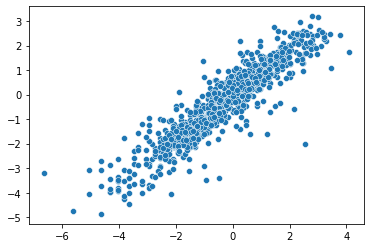

In [27]:
sns.scatterplot(x=y_true, y=y_pred)

<AxesSubplot:xlabel='MSE', ylabel='MAE'>

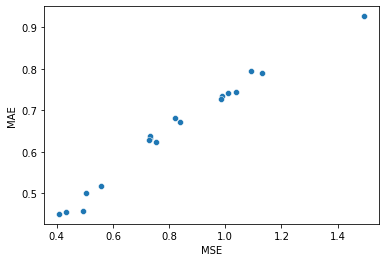

In [28]:
sns.scatterplot(data=df21, x='MSE', y='MAE')

III.4. Scatterplot valeurs réelles

In [79]:
def v_reelles():
    Model = 'XGBoost'
    energystarscore = True
    drop_NaN = True
    Y = to_predict
    dico = {'Log2_GHGEmissionsIntensity' : 'GHGEmissionsIntensity', 'Log2_SiteEUIWN':'SiteEUIWN'}
    y_true2 = 2**(y_true)
    y_pred2 = 2**(y_pred)
    mse = mean_squared_error(y_true2, y_pred2)
    r2 = r2_score(y_true2, y_pred2)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true2, y_pred2)
    l = [Model,np.nan,energystarscore, drop_NaN, dico[Y], round(mse, 4), 
    round(rmse, 4), round(mae, 4), round(r2, 4)]
    results = pd.DataFrame(l).T
    results.columns = ['Model', 'Hyperparams','NRJStarScore','drop_NaN','y','MSE','RMSE','MAE','R2']
    fig = sns.scatterplot(x=y_true2, y=y_pred2).set(title=f'{Model} model (R2={round(r2, 4)}) with real values')
    plt.xlabel(f'y_true ({dico[Y]})')
    plt.ylabel('y_predict')
    plt.savefig(f'Scatter_plots/{Model}_to_predict_{dico[Y]}.png')
    return results

,Model,Hyperparams,NRJStarScore,drop_NaN,y,MSE,RMSE,MAE,R2
0,XGBoost,NaN,True,True,GHGEmissionsIntensity,1.0015,1.0008,0.4296,0.666


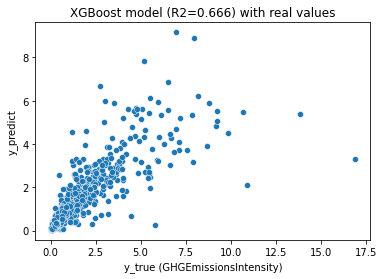

In [81]:
v_reelles()

# IV. SHAP VALUES

# /!\ avec EnergyStarScore+drop_NaN

In [30]:
best = df21[df21['R2']==df21['R2'].max()]

In [31]:
best

,Model,Hyperparams,Time_(s),NRJStarScore,drop_NaN,Group,y,MSE,RMSE,MAE,R2
8,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'min_ch...",273.03,True,True,Avec_NRJStarS+drop_Nan,Log2_GHGEmissionsIntensity,0.4096,0.64,0.4508,0.8482


In [32]:
def shap_val(data="train"):
    dico = {'RF':RandomForestRegressor(),"LR":LinearRegression(), "XGBoost":XGBRegressor(), 
    'LGB':lgb.LGBMRegressor(),'SVR':SVR(), 'GBR':GradientBoostingRegressor()}
    hyper = eval(best.at[best.index.item(), 'Hyperparams'])
    model = dico[best.at[best.index.item(), 'Model']]
    model.set_params(**hyper)
    #model = XGBRegressor(n_estimators=hyper['n_estimators'],
     #       max_depth=hyper['max_depth'],
      #      learning_rate=hyper['learning_rate'], min_child_weight=hyper['min_child_weight'])
    df = df19[df19['ENERGYSTARScore'].notna()]
    X = df.iloc[:,3:36]
    y = df[to_predict]
    X = np.array(X)
    y = np.array(y)
    folds= KFold(random_state=50, shuffle=True, n_splits=10).split(X, y) #définir le kfold
    y_pred = []
    y_true = []
    for train, test in folds:
        y_pred.append(model.fit(X[train], y[train]).predict(X[test]))
        y_true.append(y[test])
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    X_train = pd.DataFrame(X[train], columns = df.iloc[:,3:36].columns.to_list())
    y_train = pd.DataFrame(y[train], columns = [to_predict])
    X_test = pd.DataFrame(X[test], columns = df.iloc[:,3:36].columns.to_list())
    X = pd.DataFrame(X, columns = df.iloc[:,3:36].columns.to_list())
    y = pd.DataFrame(y, columns = [to_predict])
    if data=='train':
        model.fit(X_train, y_train) #on peut tester avec X et y
        explainer = shap.Explainer(model.predict, X_test) # Fits the explainer (ou X au lieu de X_test)
        shap_values = explainer(X_test) 
    else:
        model.fit(X, y)
        explainer = shap.Explainer(model.predict, X)
        shap_values = explainer(X) # Calculates the SHAP values - It takes some time
    return shap_values, X_test, X.columns, X

In [33]:
shap_values = shap_val(data='all')[0]

Permutation explainer: 982it [00:46, 17.59it/s]                         


Note : The shap_values variable will have three attributes: .values, .base_values and .data.

The .dataattribute is simply a copy of the input data, .base_values is the expected value of the target, or the average target value of all the train data, and .values are the SHAP values for each example.

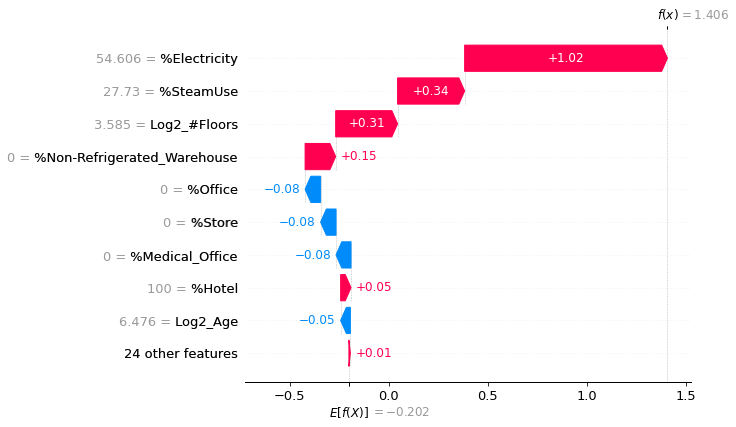

In [34]:
shap.plots.waterfall(shap_values[0]) #ind par individu, ici ligne 0

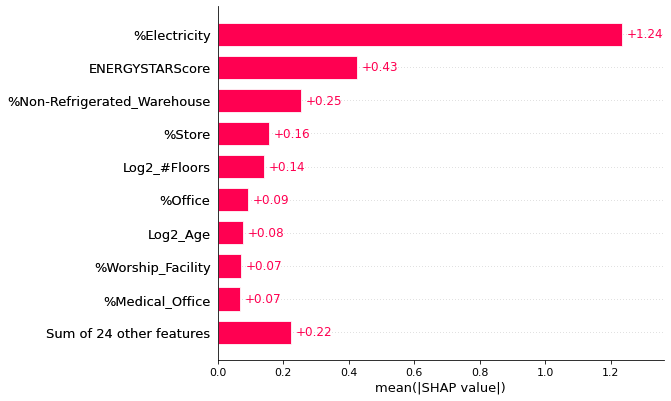

In [35]:
shap.plots.bar(shap_values,
              max_display=10)

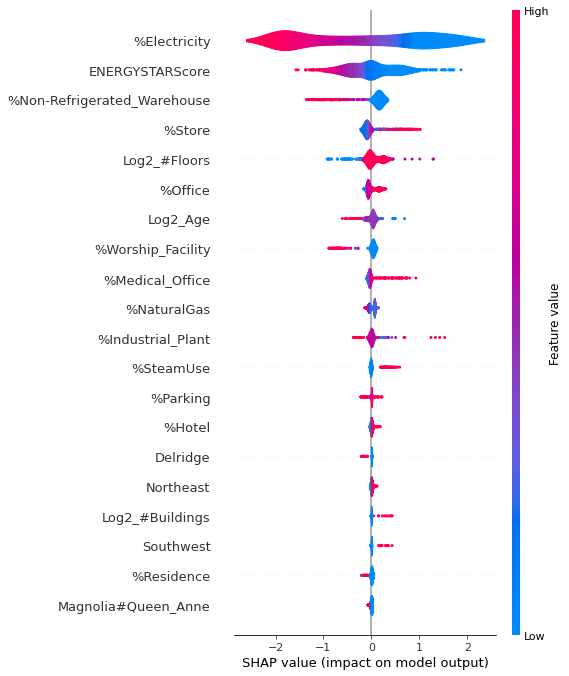

In [36]:
shap.summary_plot(shap_values, plot_type='violin')

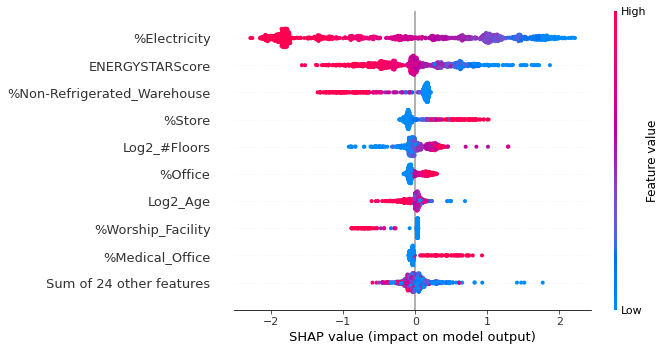

In [37]:
shap.plots.beeswarm(shap_values)

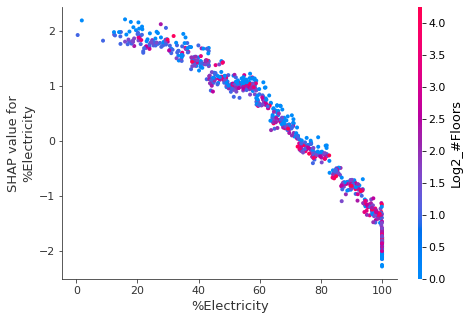

In [38]:
shap.dependence_plot("%Electricity", shap_values.values, shap_val()[3]) #si model.fit(X,y)

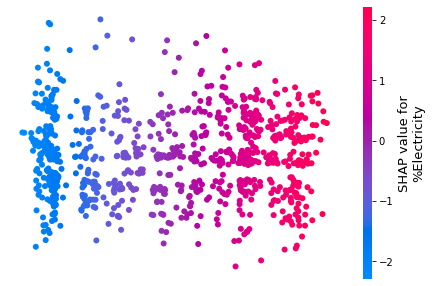

In [39]:
shap.embedding_plot("%Electricity",shap_values.values, shap_val()[2])

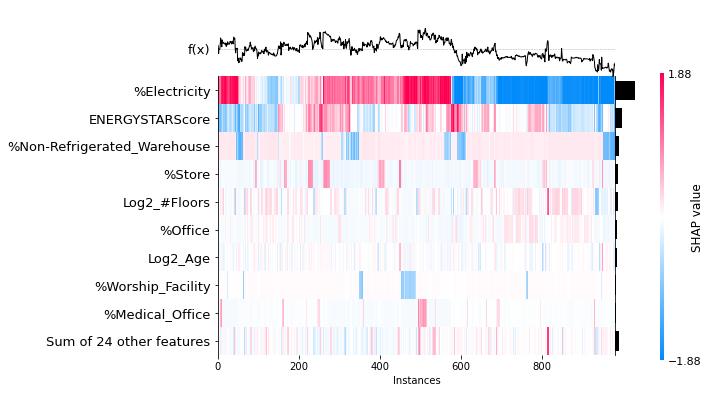

In [40]:
shap.plots.heatmap(shap_values)